In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
warnings.filterwarnings('ignore')


In [ ]:
movies = pd.read_csv("https://raw.githubusercontent.com/lexie21/recommender/main/model/movies_data/imdb_folder/movies_metadata.csv")
ratings = pd.read_csv("https://raw.githubusercontent.com/lexie21/recommender/main/model/movies_data/imdb_folder/ratings_small.csv")
keywords = pd.read_csv("https://raw.githubusercontent.com/lexie21/recommender/main/model/movies_data/imdb_folder/keywords.csv")

In [ ]:
movies["release_date"].apply(lambda x: int(x.split('-')[0]) if isinstance(x,str) else 0)

,release_date
0,1995
1,1995
2,1995
3,1995
4,1995
...,...
45461,0
45462,2011
45463,2003
45464,1917


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [ ]:
print(ratings.shape)

(100004, 4)


In [ ]:
print(ratings["userId"].nunique())
print(ratings["movieId"].nunique())


671
9066


Text(0.5, 1.0, 'Average small rating by movie')

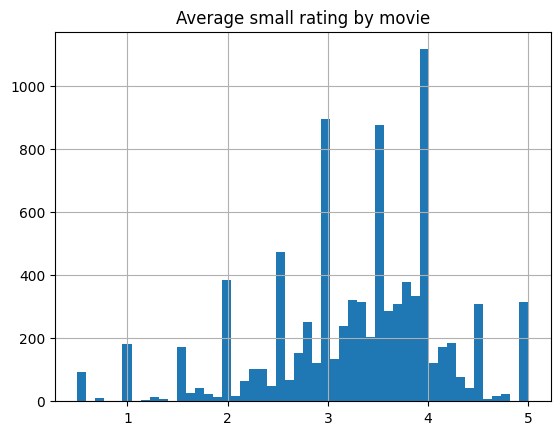

In [ ]:
# most raters are quite generous
# let's see rating distribution by movie_id and user_id
# average rating for each movie
plt.hist(ratings.groupby("movieId")["rating"].mean(),bins=50)
plt.grid(True);
plt.title("Average small rating by movie")

Text(0.5, 1.0, 'Average full rating by movie')

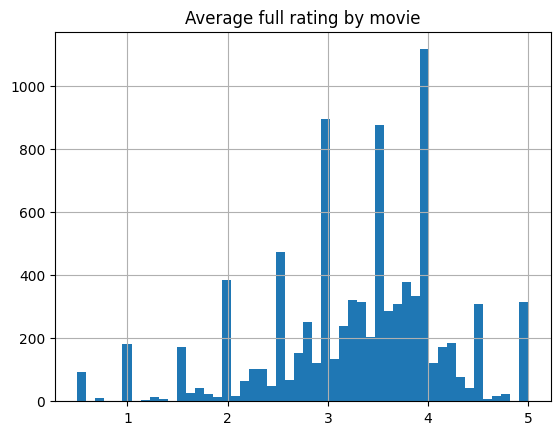

In [ ]:
plt.hist(ratings.groupby("movieId")["rating"].mean(),bins=50)
plt.grid(True);
plt.title("Average full rating by movie")

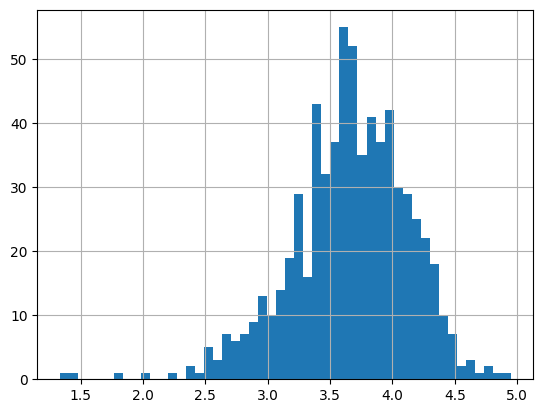

In [ ]:
# average rating given by each user
plt.hist(ratings.groupby("userId")["rating"].mean(),bins=50)
plt.grid(True);

In [ ]:
#ToDos: vectorize using tfidf, count and wordvec, then hstack with numerical feature, then put in cosine simil => done
# DL
# collab filter with KNN
# Matrix fact

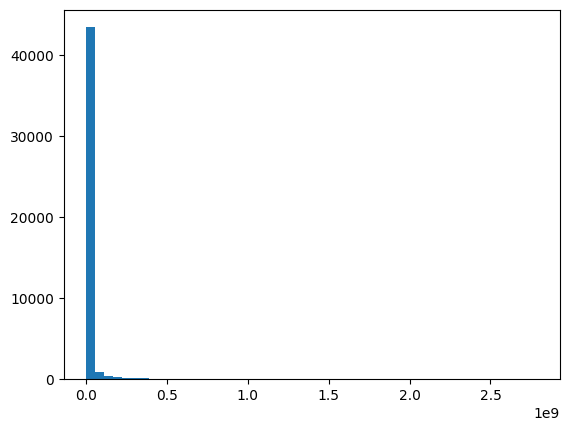

In [ ]:
plt.hist(movies["revenue"],bins=50); # most are 0 => drop

In [ ]:
movies[movies["budget"] == '0']["release_date"].describe() # missing budget info for movies from 1917 to 2004 => keep

,release_date
count,36490
unique,16137
top,2008-01-01
freq,123


In [ ]:
# preprocessing
class FeatureBuilder:
    def __init__(self, raw_df: pd.DataFrame, raw_keywords: pd.DataFrame, lowtime = 45, hightime = 300):
        self.raw_df = raw_df
        if self.raw_df["id"].dtype != int:
          self.raw_df.drop(self.raw_df[self.raw_df["id"].apply(lambda x: '-' in x)].index, inplace=True)
        self.raw_df["id"] = self.raw_df["id"].astype(int)
        self.raw_df["overview"] = self.raw_df["overview"].fillna('').apply(lambda x: str.lower(x))
        # self.raw_df["release_date"] = self.raw_df["release_date"].apply(lambda x: int(x.split('-')[0]) if isinstance(x,str) else 0)
        # self.raw_df["budget"] = self.raw_df["budget"].apply(lambda x: float(x) if isinstance(x, str) else 0.0)
        self.raw_df = pd.merge(self.raw_df, raw_keywords, on="id")
        self.qualified_df = pd.DataFrame()


    def weighted_scores(self, percentile = 0.8):
        print(f"Initial shape: {self.raw_df.shape}")
        minimum_vote = self.raw_df["vote_count"].quantile(percentile)
        qualified_movies = self.raw_df[self.raw_df["vote_count"] >= minimum_vote]
        average_vote = qualified_movies["vote_average"].mean()
        qualified_movies["score"] = ((qualified_movies["vote_count"]/(qualified_movies["vote_count"]+minimum_vote))*qualified_movies["vote_average"]) + ((minimum_vote/(qualified_movies["vote_count"] + minimum_vote))*average_vote)

        self.qualified_df = qualified_movies
        print(f"Qualified shape: {self.qualified_df.shape}")
        return self

    def destring(self, vars):
        def generate_list(x):
            if isinstance(x, list):
                names = [i["name"] for i in x]
                return names
            return []

        def sanitize(x):
            if isinstance(x, list):
                return [str.lower(i.replace(" ", "")) for i in x]
            else:
                if isinstance(x, str):
                    return str.lower(x.replace(" ", ""))
                else:
                    return ''

        def create_soup(x):
            return ' '.join(x["title"]) +' '.join(x["production_companies"]) +  ' '.join(x["spoken_languages"]) + ' '.join(x["keywords"]) + ' '.join(x["genres"]) + ' '.join(x["overview"])

        for var in vars:
            self.qualified_df[var] = self.qualified_df[var].fillna('[]').apply(literal_eval)
            self.qualified_df[var] = self.qualified_df[var].apply(generate_list)
            self.qualified_df[var] = self.qualified_df[var].apply(sanitize)

        self.qualified_df["soup"] = self.qualified_df.apply(create_soup, axis=1)

        return self

    def encoding(self):
        multihot = MultiLabelBinarizer()
        genres_encoded = multihot.fit_transform(self.qualified_df["genres"])
        encoded_df = pd.DataFrame(genres_encoded,columns=multihot.classes_)
        self.qualified_df = pd.merge(self.qualified_df.drop("genres",axis=1),encoded_df,right_index=True,left_index=True)
        return self

    def drop_cols(self):
        drop_cols = ["adult","belongs_to_collection", "homepage","imdb_id","original_title","original_language","poster_path","production_countries","status",
             "tagline","video","revenue","popularity"]
        self.qualified_df = self.qualified_df.drop(drop_cols,axis=1)
        return self

def run_processing_pipeline(
        feature_builder: FeatureBuilder
) -> pd.DataFrame:
    return (
        feature_builder.weighted_scores()
        .destring(vars=["keywords", "genres","spoken_languages","production_companies","title"])
        .encoding()
        .drop_cols()
    )



In [ ]:
feature_store =  run_processing_pipeline(FeatureBuilder(movies, keywords)).qualified_df
feature_store.head()


Initial shape: (46482, 25)
Qualified shape: (9384, 26)


,budget,id,overview,production_companies,release_date,runtime,spoken_languages,title,vote_average,vote_count,...,history,horror,music,mystery,romance,sciencefiction,thriller,tvmovie,war,western
0,30000000,862,"led by woody, andy's toys live happily in his ...",[pixaranimationstudios],1995-10-30,81.0,[english],Toy Story,7.7,5415.0,...,0,0,0,0,0,0,0,0,0,0
1,65000000,8844,when siblings judy and peter discover an encha...,"[tristarpictures, teitlerfilm, interscopecommu...",1995-12-15,104.0,"[english, français]",Jumanji,6.9,2413.0,...,0,0,0,0,0,0,0,0,0,0
2,0,15602,a family wedding reignites the ancient feud be...,"[warnerbros., lancastergate]",1995-12-22,101.0,[english],Grumpier Old Men,6.5,92.0,...,0,0,0,0,1,0,0,0,0,0
4,0,11862,just when george banks has recovered from his ...,"[sandollarproductions, touchstonepictures]",1995-02-10,106.0,[english],Father of the Bride Part II,5.7,173.0,...,0,0,0,0,0,0,1,0,0,0
5,60000000,949,"obsessive master thief, neil mccauley leads a ...","[regencyenterprises, forwardpass, warnerbros.]",1995-12-15,170.0,"[english, español]",Heat,7.7,1886.0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
features = feature_store.drop(["id","overview","production_companies","spoken_languages","keywords","title"],axis=1)

In [ ]:
features["budget"] = features["budget"].apply(lambda x: float(x) if isinstance(x,str) else 0.0)
features["release_date"] = features["release_date"].apply(lambda x: int(x.split("-")[0]) if isinstance(x,str) else 0)

In [ ]:
features.dtypes # preprocessing done

,0
budget,float64
release_date,int64
runtime,float64
vote_average,float64
vote_count,float64
score,float64
action,int64
adventure,int64
animation,int64
comedy,int64


In [ ]:
features_filtering = features.drop(["vote_average","vote_count","score"],axis=1)

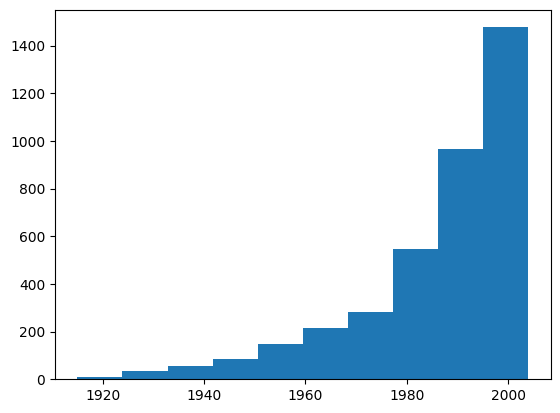

In [ ]:
plt.hist(features["release_date"]); # not building a model so scaling not necessary

In [ ]:
scl = StandardScaler()
scaled_date = scl.fit_transform(features[["release_date"]])

In [ ]:
features["release_date"] = scaled_date

In [ ]:
tfidf = TfidfVectorizer(min_df=3,  max_features=None,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
soup_vectorized = tfidf.fit_transform(feature_store["soup"])

svd = TruncatedSVD(n_components=120)
soup_svd = svd.fit_transform(soup_vectorized)

soup_svd.shape

(3822, 120)

In [ ]:
movies.shape

(45463, 24)

In [ ]:
text_simil = cosine_similarity(soup_svd)

In [ ]:
text_simil.shape

(3822, 3822)

In [ ]:
numeric_simil = cosine_similarity(features.values)

In [ ]:
numeric_simil.shape

(3822, 3822)

In [ ]:
# weighted average between the 2, just arbitrary judgment, more weight to text
final_simil = (3*text_simil + 2*numeric_simil)/5

In [ ]:
final_simil

array([[1.        , 0.73644547, 0.31817652, ..., 0.7373247 , 0.26056424,
        0.66145999],
       [0.73644547, 1.        , 0.38987848, ..., 0.730098  , 0.33119559,
        0.6932441 ],
       [0.31817652, 0.38987848, 1.        , ..., 0.30217675, 0.72437024,
        0.22783577],
       ...,
       [0.7373247 , 0.730098  , 0.30217675, ..., 1.        , 0.3002903 ,
        0.58170103],
       [0.26056424, 0.33119559, 0.72437024, ..., 0.3002903 , 1.        ,
        0.19799693],
       [0.66145999, 0.6932441 , 0.22783577, ..., 0.58170103, 0.19799693,
        1.        ]])

In [ ]:
simil_df = pd.DataFrame(final_simil, columns=feature_store.id, index=feature_store.id)

In [ ]:
simil_df

id,862,8844,15602,11862,949,11860,9091,710,9087,12110,...,10726,9298,437,27324,14752,11178,11427,4689,12720,5552
id,,,,,,,,,,,,,,,,,,,,,
862,1.000000,0.736445,0.318177,0.269977,0.714497,0.695512,0.696810,0.674726,0.681821,0.232170,...,0.640965,0.302108,0.275891,0.254369,0.669717,0.308801,0.223181,0.737325,0.260564,0.661460
8844,0.736445,1.000000,0.389878,0.308802,0.746662,0.707335,0.769202,0.716829,0.711695,0.304769,...,0.716299,0.343928,0.368932,0.359768,0.755917,0.388539,0.255964,0.730098,0.331196,0.693244
15602,0.318177,0.389878,1.000000,0.708256,0.299688,0.265291,0.339319,0.261042,0.305070,0.677494,...,0.344703,0.649110,0.594873,0.712245,0.328303,0.725251,0.659184,0.302177,0.724370,0.227836
11862,0.269977,0.308802,0.708256,1.000000,0.294993,0.282582,0.309523,0.285595,0.360620,0.666363,...,0.303830,0.724362,0.610976,0.734197,0.305305,0.716044,0.656602,0.334981,0.680261,0.213427
949,0.714497,0.746662,0.299688,0.294993,1.000000,0.676168,0.725966,0.706840,0.692933,0.262237,...,0.697530,0.306687,0.355817,0.310683,0.718118,0.293882,0.223950,0.681578,0.338109,0.660083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11178,0.308801,0.388539,0.725251,0.716044,0.293882,0.271603,0.370469,0.301016,0.280325,0.641222,...,0.326765,0.715962,0.654271,0.769528,0.299864,1.000000,0.694874,0.341376,0.738910,0.217818
11427,0.223181,0.255964,0.659184,0.656602,0.223950,0.241664,0.252513,0.237651,0.212719,0.662943,...,0.250827,0.614379,0.631404,0.656147,0.207930,0.694874,1.000000,0.253792,0.697428,0.222962
4689,0.737325,0.730098,0.302177,0.334981,0.681578,0.675162,0.721529,0.726103,0.663173,0.280623,...,0.684330,0.306810,0.240159,0.327220,0.697099,0.341376,0.253792,1.000000,0.300290,0.581701


In [ ]:
# mapping of title with id
def recommend(id):
  print(feature_store[feature_store["id"]==id]["title"])
  ids = simil_df[id].sort_values(ascending=False)[1:11].index
  return [feature_store[feature_store["id"] == id]["title"].tolist()[0] for id in ids]

In [ ]:
# try some more movies
[title for title in feature_store["title"].values]

['Toy Story',
 'Jumanji',
 'Grumpier Old Men',
 'Father of the Bride Part II',
 'Heat',
 'Sabrina',
 'Sudden Death',
 'GoldenEye',
 'The American President',
 'Dracula: Dead and Loving It',
 'Balto',
 'Nixon',
 'Cutthroat Island',
 'Casino',
 'Sense and Sensibility',
 'Four Rooms',
 'Ace Ventura: When Nature Calls',
 'Money Train',
 'Get Shorty',
 'Copycat',
 'Assassins',
 'Powder',
 'Leaving Las Vegas',
 'Now and Then',
 'The City of Lost Children',
 'Dangerous Minds',
 'Twelve Monkeys',
 'Babe',
 'Dead Man Walking',
 'It Takes Two',
 'Clueless',
 'Richard III',
 'Dead Presidents',
 'Mortal Kombat',
 'To Die For',
 'Se7en',
 'Pocahontas',
 'The Usual Suspects',
 'Mighty Aphrodite',
 'The Postman',
 'The Indian in the Cupboard',
 'Eye for an Eye',
 "Mr. Holland's Opus",
 "Don't Be a Menace to South Central While Drinking Your Juice in the Hood",
 'Bio-Dome',
 'Friday',
 'From Dusk Till Dawn',
 'Fair Game',
 'Screamers',
 'The Crossing Guard',
 'The Juror',
 "Things to Do in Denver When

In [ ]:
recommend(3170)

1917    Bambi
Name: title, dtype: object


['Spirit: Stallion of the Cimarron',
 'Beauty and the Beast',
 'Sinbad: Legend of the Seven Seas',
 'Little Black Book',
 'The Notebook',
 'All the Pretty Horses',
 'Gattaca',
 'Grave of the Fireflies',
 'Return of the Jedi',
 'The Hunchback of Notre Dame']

In [ ]:
recommend(8844) # but Lord of the Flies is horror, examine why below = overview quite similar

1    Jumanji
Name: title, dtype: object


['Lord of the Flies',
 'Digimon: The Movie',
 'Jeepers Creepers',
 'The Train',
 'Casper',
 'The Money Pit',
 'Human Traffic',
 'Slackers',
 'Evolution',
 'Godzilla']

In [ ]:
movies[movies["title"]=='Godzilla']["id"] # oops, missed duplicates

,id
1773,929
2250,1678
23360,124905


In [ ]:
movies[movies["id"]==8844]["overview"].values # overview of jumanji

array(["when siblings judy and peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite alan -- an adult who's been trapped inside the game for 26 years -- into their living room. alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures."],
      dtype=object)

In [ ]:
movies[movies["id"]==9960]["overview"].values # overview of lord of the flies

array(['amidst a nuclear war, a plane carrying a group of schoolboys crash lands on a deserted island. with no adult survivors, the boys are forced to fend for themselves. at first they cooperate, but when the they split into two separate camps -- one led by the pragmatic ralph and the other by militaristic jack -- their society falls into disarray, leading to a disturbing examination of human nature and a chilling conclusion.'],
      dtype=object)

In [ ]:
# now let's sprinkle a bit of collaborative filtering through KNN, we'll stay away from the rating matrix
from sklearn.neighbors import NearestNeighbors

In [ ]:
features_filtering.head() # bug with title preprocessing but pass for now, also need to standardize budget, use simil_df

,budget,release_date,runtime,action,adventure,animation,comedy,crime,documentary,drama,...,history,horror,music,mystery,romance,sciencefiction,thriller,tvmovie,war,western
0,30000000.0,0.496932,81.0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,65000000.0,0.496932,104.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.496932,101.0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.0,0.496932,106.0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
5,60000000.0,0.496932,170.0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
knn = NearestNeighbors(n_neighbors=100,metric="cosine")


In [ ]:
knn.fit(features_filtering) # need to drop id

NearestNeighbors(metric='cosine', n_neighbors=100)

In [ ]:
df = pd.merge(features_filtering,feature_store["id"],left_index=True,right_index=True)

In [ ]:
df.head()

,budget,release_date,runtime,action,adventure,animation,comedy,crime,documentary,drama,...,horror,music,mystery,romance,sciencefiction,thriller,tvmovie,war,western,id
0,30000000.0,0.496932,81.0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,862
1,65000000.0,0.496932,104.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8844
2,0.0,0.496932,101.0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,15602
4,0.0,0.496932,106.0,1,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,11862
5,60000000.0,0.496932,170.0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,949


In [ ]:
def recommend2(id):

  ids = knn.kneighbors(df[df["id"] == id].drop("id",axis=1))[1][0]
  mapping = pd.DataFrame(feature_store["title"].values,index=feature_store["id"].values)
  return [mapping.iloc[id].tolist()[0] for id in ids[1:11]]

In [ ]:
recommend2(3170) # recommendation for Bambi

['The Lost Weekend',
 'The Trouble with Harry',
 'Ninotchka',
 'The African Queen',
 'The Best Years of Our Lives',
 '3 Women',
 'The Rocky Horror Picture Show',
 'Ghoulies',
 'Roman Holiday',
 'Strangers on a Train']

In [ ]:
recommend2(8844) # recommendation for Jumanji

['Event Horizon',
 'Deep Impact',
 'Red Dragon',
 "Something's Gotta Give",
 'The Manchurian Candidate',
 'Lucky Numbers',
 'Cast Away',
 'Harry Potter and the Chamber of Secrets',
 'Seabiscuit',
 'The Bone Collector']

In [ ]:
recommend2(929) # for Godzilla

['Armageddon',
 'Judge Dredd',
 'Tomorrow Never Dies',
 'Finding Nemo',
 'Lilo & Stitch',
 'Harry Potter and the Prisoner of Azkaban',
 "Charlie's Angels",
 'The Flintstones in Viva Rock Vegas',
 'Sleepy Hollow',
 'Little Nicky']